In [1]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [2]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
X_train = batch_1['data']
X_train.shape

(10000, 3072)

In [4]:
Y_train = batch_1['labels']
len(Y_train)

10000

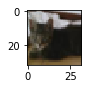

In [5]:
import matplotlib.pyplot as plt
import scipy
import scipy.misc
%matplotlib inline
import numpy as np
%matplotlib inline
plt.figure(figsize =(1,1))
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (32,32)) 
plt.imshow(image)

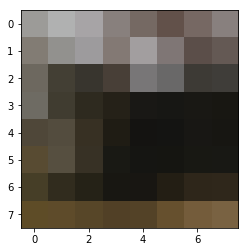

In [6]:
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (8,8)) 
plt.imshow(image)

In [7]:
def leaky_relu_and_bn(X, bn_name, alpha=0.3):
    X = tf.layers.batch_normalization(X, name=bn_name)
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
# Discriminator
# -----
# Phase: 0 (initial)
# Input: 3 x 4 x 4

# Block: from_rgb_4
# c1 (from_rbg): 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 1 (add 1)
# Input: 3 x 8 x 8

# Block: from_rgb_8
# c1 (from_rbg): 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 2 (add 2)
# Input: 3 x 16 x 16

# Block: from_rgb_16
# c1 (from_rbg): 32 x 16 x 16

# Block: added_16_to_8
# c3: 32 x 16 x 16
# c3: 64 x 16 x 16
# dn: 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# -----
# Phase: 3 (add 3)
# Input: 3 x 32 x 32

# Block: from_rgb_32
# c1 (from_rbg): 16 x 32 x 32

# Block: added_32_to_16
# c3: 16 x 32 x 32
# c3: 32 x 32 x 32
# dn: 32 x 16 x 16

# Block: added_16_to_8
# c3: 32 x 16 x 16
# c3: 64 x 16 x 16
# dn: 64 x 8 x 8

# Block: added_8_to_4
# c3: 64 x 8 x 8
# c3: 128 x 8 x 8
# dn: 128 x 4 x 4

# Block: out
# c3: 128 x 4 x 4
# c4: 128 x 1 x 1
# fc: 1 x 1 x 1

# ><><><><><><><><><><><><

# Generator
# ------
# Phase: 0 (Initial)
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: to_rgb_4
# c1 (to_rgb): 3 x 4 x 4

# ----
# Phase: 1 (add 1)
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: to_rgb_8
# c1 (to_rgb): 3 x 8 x 8

# -----
# Phase: 2 (add 2)
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: added_8_to_16
# up: 64 x 16 x 16
# c3: 32 x 16 x 16
# c3: 32 x 16 x 16

# Block: to_rgb_16
# c1 (to_rgb): 3 x 16 x 16

# ----
# Phase: 3 (add 3)
# Input z: 128 x 1 x 1

# Block: initial
# c4: 128 x 4 x 4
# c3: 128 x 4 x 4

# Block: added_4_to_8
# up: 128 x 8 x 8
# c3: 64 x 8 x 8
# c3: 64 x 8 x 8

# Block: added_8_to_16
# up: 64 x 16 x 16
# c3: 32 x 16 x 16
# c3: 32 x 16 x 16

# Block: added_16_to_32
# up: 32 x 32 x 32
# c3: 16 x 32 x 32
# c3: 16 x 32 x 32

# Block: to_rgb_32
# c1 (to_rgb): 3 x 32 x 32

In [10]:
# Config:
batch_size = 32
num_images_before_adding_block_constant = 64
num_epochs = 1000000000
d_warm_up = 0
verbose = True
print_frequency = 1

In [11]:
def calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen):
    num_images_before_adding_block = tf.constant(num_images_before_adding_block_constant, tf.float32)

    num_blocks_to_add = tf.floor(num_images_seen / num_images_before_adding_block)
    num_blocks_to_add = tf.cond(num_blocks_to_add > 3, lambda: tf.minimum(num_blocks_to_add, tf.constant(3.0)), lambda: num_blocks_to_add)

    num_images_into_phase = num_images_seen - (num_blocks_to_add * num_images_before_adding_block)  
    smoothing_coefficient = tf.cond(num_blocks_to_add >= 3,
        lambda: tf.constant(1.0),
        lambda: tf.maximum(tf.constant(1.0), num_images_into_phase / (num_images_before_adding_block / 2)))
    
    # Don't smooth in starting resolution since there is no prior
    smoothing_coefficient = tf.cond(tf.equal(num_blocks_to_add, 0), lambda: tf.constant(1.0), lambda: smoothing_coefficient)
    
    return [num_blocks_to_add, smoothing_coefficient]

In [12]:
def leaky_relu_and_bn(X, bn_name, alpha=0.3):
    X = tf.layers.batch_normalization(X, name=bn_name)
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [13]:
# D

In [14]:
# In: batch_size, resolution, resolution, 3
# Out: batch_size, resolution, resolution, target_num_channels 
def from_rgb(X, resolution, target_num_channels, reuse=None):
    with tf.variable_scope("from_rgb_" + str(resolution)):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        X_normalized = tf.layers.batch_normalization(X, name='bn0' + str(resolution))
        w = tf.get_variable('w' + str(resolution), [1, 1, 3, target_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / target_num_channels)))
        b = tf.get_variable('b' + str(resolution), [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))
        conv = tf.nn.conv2d(X_normalized, w, [1,1,1,1], padding='SAME') + b
        return leaky_relu_and_bn(conv, 'bn1' + str(resolution))

In [15]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 4*2^phase, 4*2^phase, 128/(2^phase)
def from_rgb_for_phase(X, phase, reuse=None):
    return tf.case([
            (tf.equal(phase, tf.constant(0.0)), lambda: from_rgb(X, 4, 128, reuse)),
            (tf.equal(phase, tf.constant(1.0)), lambda: from_rgb(X, 8, 64, reuse)),
            (tf.equal(phase, tf.constant(2.0)), lambda: from_rgb(X, 16, 32, reuse)),
            (tf.equal(phase, tf.constant(3.0)), lambda: from_rgb(X, 32, 16, reuse)),
        ], default=lambda: tf.zeros((1,4,4,128)))

In [16]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 4*2^phase, 4*2^phase, 128/(2^phase) 
def from_rgb_possibly_smoothed(X, phase, smoothing_coefficient):
    from_rgb = from_rgb_for_phase(X, phase)
    
    def smoothed():
        half_resolution_X = tf.nn.avg_pool(X, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')
        prior_from_rgb = from_rgb_for_phase(half_resolution_X, phase - 1, True)
        return (1 - smoothing_coefficient) * prior_from_rgb + smoothing_coefficient * from_rgb
    
    return tf.cond(smoothing_coefficient < 1.0, smoothed, lambda: from_rgb)

In [17]:
# In: batch_size, input_resolution, input_resolution, input_num_channels
# Out: batch_size, input_resolution / 2, input_resolution / 2, 2 * input_num_channels
def added_discriminator_block(X, input_resolution, input_num_channels):
    target_resolution = input_resolution / 2
    target_num_channels = 2 * input_num_channels
    with tf.variable_scope("added_" + str(input_resolution) + "_to_" + str(target_resolution)):
        w1 = tf.get_variable('w1', [3, 3, input_num_channels, input_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / input_num_channels)))
        b1 = tf.get_variable('b1', [input_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv1 = tf.nn.conv2d(X, w1, [1,1,1,1], padding='SAME', name='conv1') + b1
        a1 = leaky_relu_and_bn(conv1, 'bn1')

        w2 = tf.get_variable('w2', [3, 3, input_num_channels, target_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / input_num_channels)))
        b2 = tf.get_variable('b2', [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv2 = tf.nn.conv2d(a1, w2, [1,1,1,1], padding='SAME', name='conv2') + b2
        a2 = leaky_relu_and_bn(conv2, 'bn2')  

        return tf.nn.avg_pool(a2, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')

In [18]:
# In: batch_size, 4, 4, 128
# Out: batch_size, 1, 1, 1
def discriminator_output_block(X):
    with tf.variable_scope("output_block"):
        w1 = tf.get_variable('w1', [3, 3, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b1 = tf.get_variable('b1', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv1 = tf.nn.conv2d(X, w1, [1,1,1,1], padding='SAME') + b1
        a1 = leaky_relu_and_bn(conv1, 'bn1')

        w2 = tf.get_variable('w2', [4, 4, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b2 = tf.get_variable('b2', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv2 = tf.nn.conv2d(a1, w2, [1,1,1,1], padding='VALID') + b2
        a2 = leaky_relu_and_bn(conv2, 'bn2')
        return tf.layers.dense(a2, 1)

In [19]:
# In: batch_size, 4*2^phase, 4*2^phase, 3
# Out: batch_size, 1, 1, 1
def discriminator(X, num_images_seen, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
        phase = num_blocks_to_add

        X = from_rgb_possibly_smoothed(X, phase, smoothing_coefficient)
        
        X = tf.cond(phase >= 3, lambda: added_discriminator_block(X, 32, 16), lambda: X)
        X = tf.cond(phase >= 2, lambda: added_discriminator_block(X, 16, 32), lambda: X)
        X = tf.cond(phase >= 1, lambda: added_discriminator_block(X, 8, 64), lambda: X)

        return discriminator_output_block(X)

In [20]:
# G

In [21]:
# In: batch_size, 128, 1, 1
# Out: batch_size, 128, 4, 4
def initial_generator_block(z):
    with tf.variable_scope("initial_block"):
        w1 = tf.get_variable('w1', [4, 4, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b1 = tf.get_variable('b1', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        conv1 = tf.nn.conv2d_transpose(z, w1, [batch_size, 4, 4, 128], [1, 1, 1, 1], padding='VALID', name='conv1') + b1      
        a1 = leaky_relu_and_bn(conv1, 'bn1')

        w2 = tf.get_variable('w2', [3, 3, 128, 128], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 128)))
        b2 = tf.get_variable('b2', [128], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        a2 = tf.nn.conv2d_transpose(a1, w2, [batch_size, 4, 4, 128], [1, 1, 1, 1], padding='SAME', name='conv2') + b2
        return leaky_relu_and_bn(a2, 'bn2')

In [22]:
# In: batch_size, starting_resolution, starting_resolution, starting_num_channels
# Out: [
#       (batch_size, 2 * starting_resolution, 2 * starting_resolution, starting_num_channels), # result after doubling
#       (batch_size, 2 * starting_resolution, 2 * starting_resolution, starting_num_channels / 2) # block output at target resolution
# ]
def added_generator_block(X, starting_resolution, starting_num_channels):
    target_resolution = 2 * starting_resolution
    target_num_channels = starting_num_channels / 2
    with tf.variable_scope("added_" + str(starting_resolution) + "_to_" + str(target_resolution)):
        double_resolution = tf.image.resize_nearest_neighbor(X, [target_resolution, target_resolution])
        w1 = tf.get_variable('w1', [3, 3, target_num_channels, starting_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / starting_num_channels)))
        b1 = tf.get_variable('b1', [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / target_num_channels)))
        deconv1 = tf.nn.conv2d_transpose(double_resolution, w1, [batch_size, target_resolution, target_resolution, target_num_channels], [1,1,1,1], padding='SAME', name='deconv1') + b1
        a1 = leaky_relu_and_bn(deconv1, 'bn1')

        w2 = tf.get_variable('w2', [3, 3, target_num_channels, target_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / target_num_channels)))
        b2 = tf.get_variable('b2', [target_num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))
        deconv2 = tf.nn.conv2d_transpose(a1, w2, [batch_size, target_resolution, target_resolution, target_num_channels], [1,1,1,1], padding='SAME', name='deconv2') + b2
        return [double_resolution, leaky_relu_and_bn(deconv2, 'bn2')]

In [23]:
# In: batch_size, resolution, resolution, input_num_channels
# Out: batch_size, resolution, resolution, 3
def to_rgb(X, resolution, input_num_channels, reuse=None):
    with tf.variable_scope("to_rgb_" + str(resolution)):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        w = tf.get_variable('w', [1, 1, 3, input_num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / input_num_channels)))
        b = tf.get_variable('b', [3], initializer = tf.truncated_normal_initializer(stddev=0.02))
        return tf.nn.conv2d_transpose(X, w, [batch_size, resolution, resolution, 3], [1,1,1,1], padding='SAME', name='conv') + b

In [24]:
def to_rgb_for_phase(X, phase, reuse=None):
    return tf.case([
        (tf.equal(phase, tf.constant(0.0)), lambda: to_rgb(X, 4, 128, reuse)),
        (tf.equal(phase, tf.constant(1.0)), lambda: to_rgb(X, 8, 64, reuse)),
        (tf.equal(phase, tf.constant(2.0)), lambda: to_rgb(X, 16, 32, reuse)),
        (tf.equal(phase, tf.constant(3.0)), lambda: to_rgb(X, 32, 16, reuse)),
    ], default=lambda: tf.zeros((1,4,4,128), tf.float32))

In [25]:
def to_rgb_possibly_smoothed(X, doubled_prior, phase, smoothing_coefficient):
    new_to_rgb = to_rgb_for_phase(X, phase) 
    return tf.cond(smoothing_coefficient < 1,
        lambda: (1 - smoothing_coefficient) * to_rgb_for_phase(doubled_prior, phase, True)  + smoothing_coefficient * new_to_rgb,
        lambda: new_to_rgb)

In [26]:
def reshape_output_for_phase(X, phase):
    # this disaster is because tf.case doesn't preserve shape
    return tf.cond(tf.equal(phase, tf.constant(0.0)), lambda: tf.reshape(X, (batch_size, 4, 4, 3)),
        lambda: tf.cond(tf.equal(phase, tf.constant(1.0)), lambda: tf.reshape(X, (batch_size, 8, 8, 3)),
            lambda: tf.cond(tf.equal(phase, tf.constant(2.0)), lambda: tf.reshape(X, (batch_size, 16, 16, 3)),
                lambda: tf.reshape(X, (batch_size, 32, 32, 3)))))                    
#     return tf.case([
#         (tf.equal(phase, tf.constant(0.0)), lambda: tf.reshape(X, (batch_size, 4, 4, 3))),
#         (tf.equal(phase, tf.constant(1.0)), lambda: tf.reshape(X, (batch_size, 8, 8, 3))),
#         (tf.equal(phase, tf.constant(2.0)), lambda: tf.reshape(X, (batch_size, 16, 16, 3))),
#         (tf.equal(phase, tf.constant(3.0)), lambda: tf.reshape(X, (batch_size, 32, 32, 3))),
#     ], default=lambda: tf.zeros((1,4,4,3), tf.float32))

In [27]:
# In: batch_size, 128
# Out: batch_size, 4*2^phase, 4*2^phase, 3
def generator(z, num_images_seen, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
        phase = num_blocks_to_add
        z_reshaped = tf.reshape(z, [batch_size, 1, 1, 128], name='z_reshape')
        
        X = initial_generator_block(z_reshaped)
        
        doubled_prior, X = tf.cond(phase >= 1, lambda: added_generator_block(X, 4, 128), lambda: [X, X])
        doubled_prior, X = tf.cond(phase >= 2, lambda: added_generator_block(X, 8, 64), lambda: [doubled_prior, X])
        doubled_prior, X = tf.cond(phase >= 3, lambda: added_generator_block(X, 16, 32), lambda: [doubled_prior, X])

        X = to_rgb_possibly_smoothed(X, doubled_prior, phase, smoothing_coefficient)
        return reshape_output_for_phase(X, phase)

In [28]:
# Train and Test

In [29]:
X = tf.placeholder(tf.float32, [batch_size, None, None, 3], name="X")
z = tf.placeholder(tf.float32, [batch_size, 128], name="z")
num_images_seen = tf.placeholder(tf.float32, name='num_images_seen')

In [30]:
Dx = discriminator(X, num_images_seen)
Gz = generator(z, num_images_seen, False)
Dg = discriminator(Gz, num_images_seen, True)

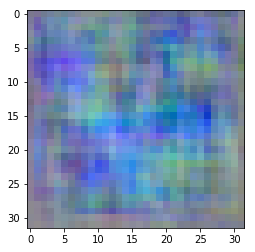

136.190429688
36.406601387


In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    z_batch = np.random.normal(0, 1, size=[batch_size, 128])
    generated_images = sess.run(Gz, feed_dict={z: z_batch, num_images_seen: 9999999})
    generated_image = generated_images[0, :, :, :]
    
    g1 = scipy.misc.imresize(generated_image, (32, 32))
    plt.imshow(g1)
    plt.show()
    print(np.mean(g1))
    print(np.var(g1) ** 0.5)

#     g2 = generated_image.reshape(32, 32, 3, order='F')
#     plt.imshow(g2)
#     plt.show()
#     print(np.mean(g2))
#     print(np.var(g2) ** 0.5)

In [32]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_cost_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [33]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'D/' in var.name]
g_vars = [var for var in t_vars if 'G/' in var.name]

In [34]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)
optimizer_d_fake = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_fake, var_list=d_vars)
optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_cost, var_list=g_vars)

In [35]:
def print_num_params(varbs):
    total_parameters = 0
    for variable in varbs:
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        total_parameters += variable_parameters
    print(total_parameters)

In [ ]:
print("All:")
print_num_params(t_vars)
print("D:")
print_num_params(d_vars)
print("G:")
print_num_params(g_vars)

All:
1115045
D:
558121
G:
556924


New image size: 4
Target:


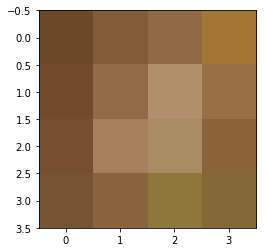

Target:


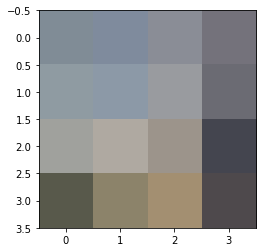

Target:


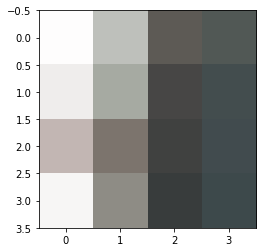

Target:


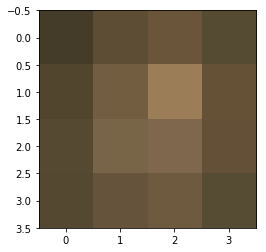

Target:


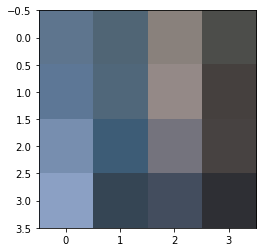

Target:


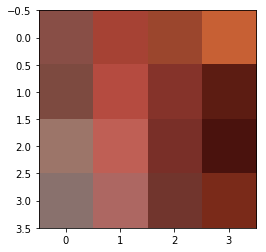

Target:


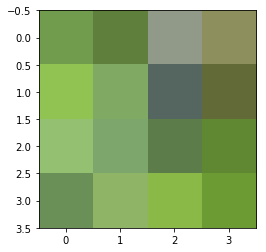

Target:


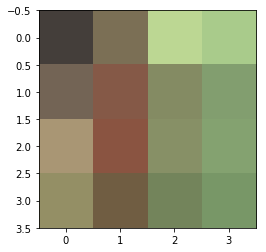

Target:


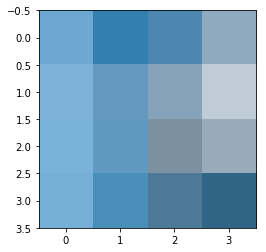

Target:


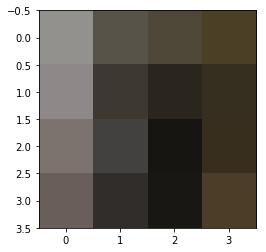

Target:


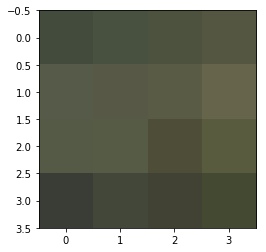

Target:


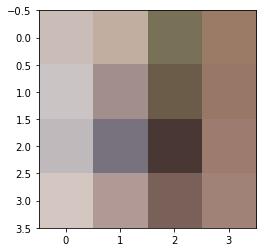

Target:


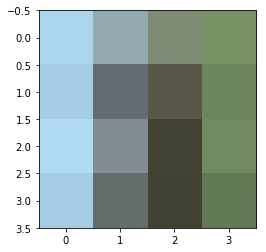

Target:


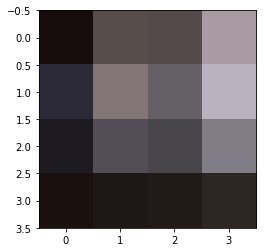

Target:


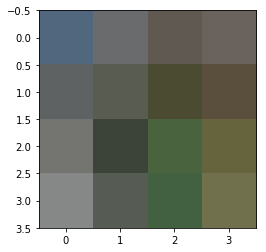

Target:


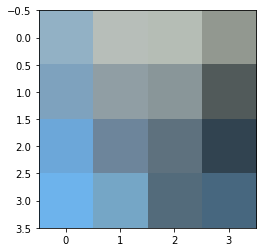

Target:


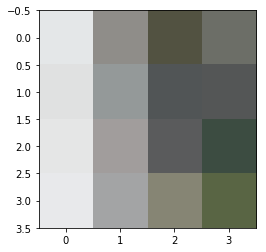

Target:


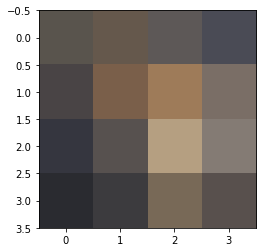

Target:


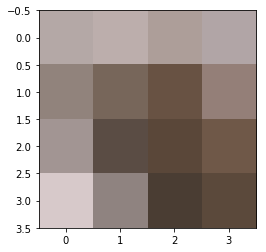

Target:


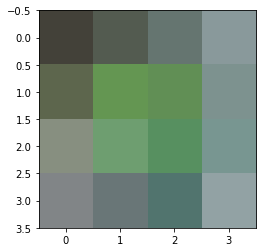

Target:


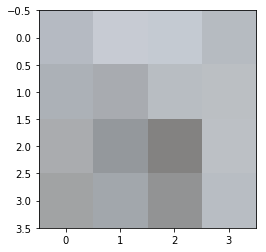

Target:


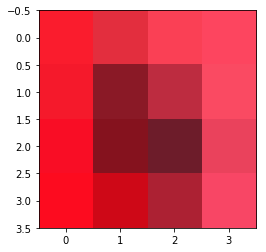

Target:


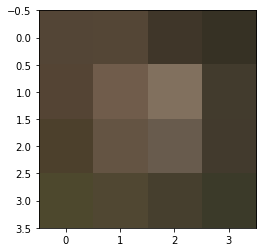

Target:


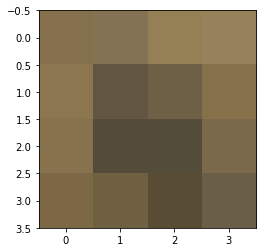

Target:


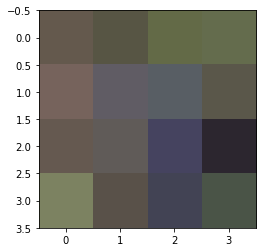

Target:


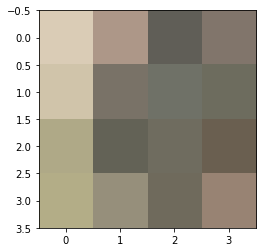

Target:


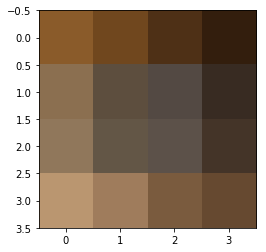

Target:


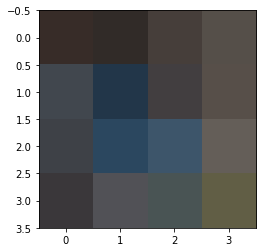

Target:


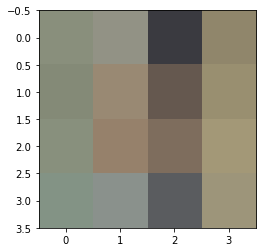

Target:


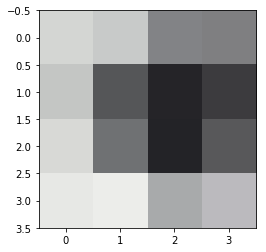

Target:


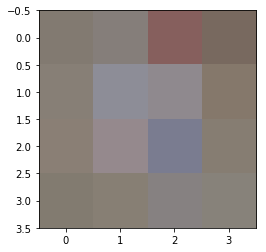

Target:


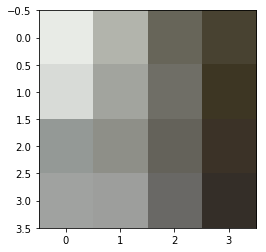

New num_block_to_add: 0
# images seen: 32
Cost Real: 16.542
Cost Fake: 1.57776
g_cost:10.7749
num to add: 0
image size: 4
Generated:


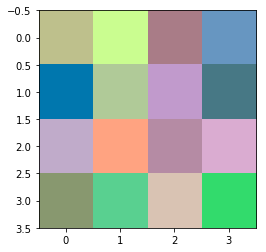

Generated:


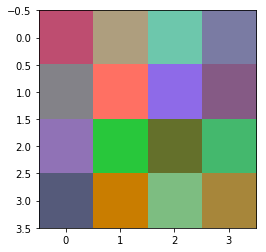

Generated:


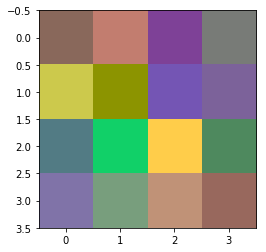

Generated:


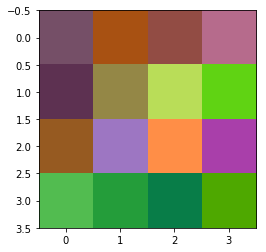

Generated:


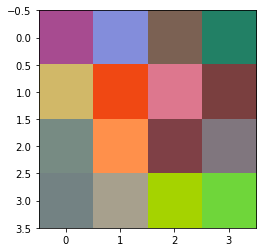

Generated:


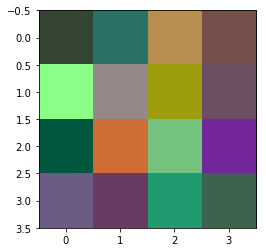

Generated:


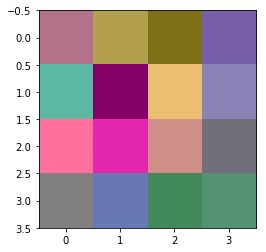

Generated:


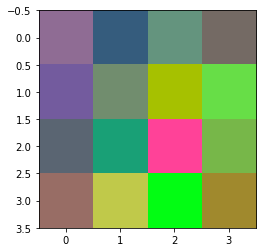

Generated:


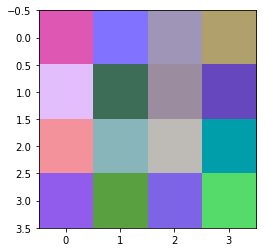

Generated:


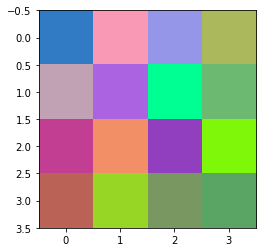

Generated:


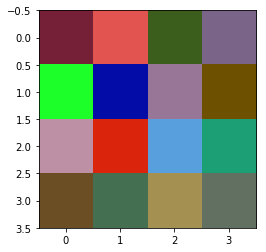

Generated:


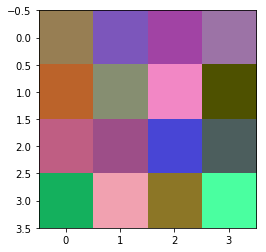

Generated:


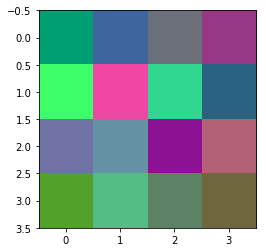

Generated:


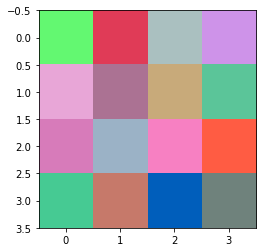

Generated:


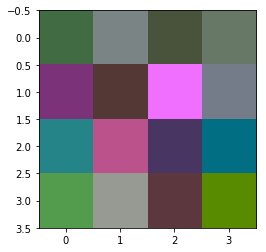

Generated:


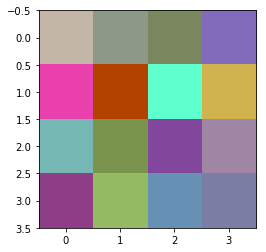

Generated:


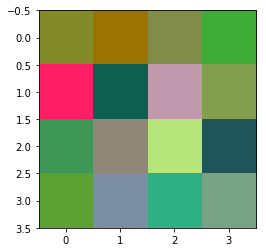

Generated:


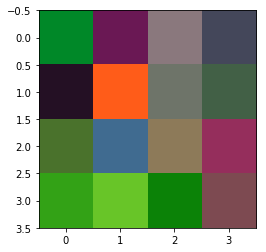

Generated:


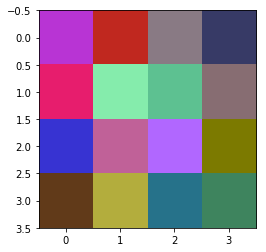

Generated:


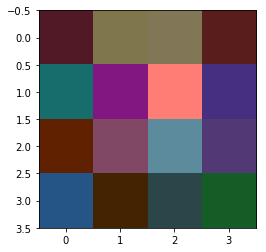

Generated:


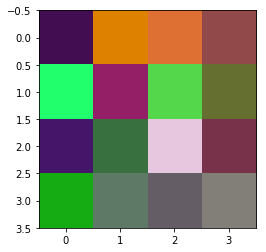

Generated:


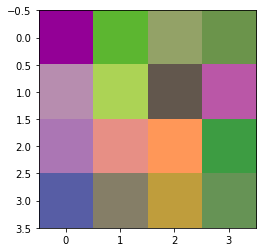

Generated:


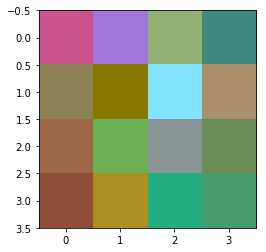

Generated:


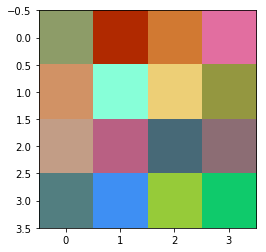

Generated:


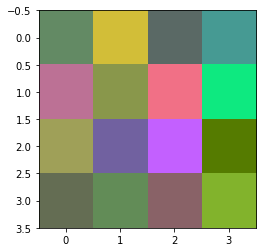

Generated:


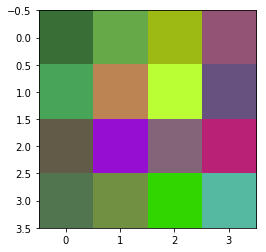

Generated:


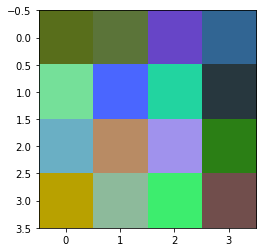

Generated:


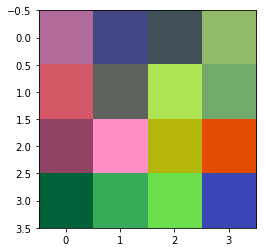

Generated:


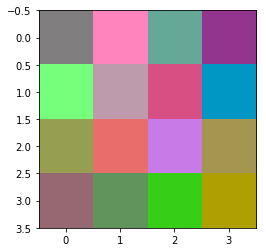

Generated:


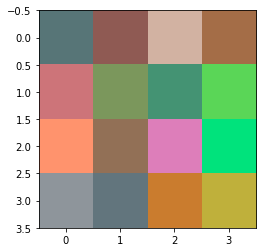

Generated:


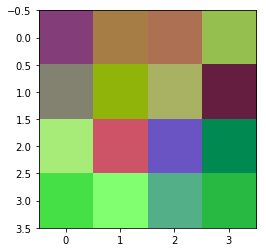

Generated:


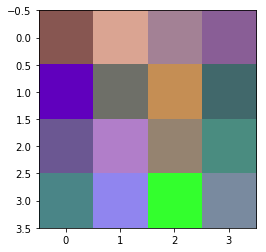

In [ ]:
import math
sample = None
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_training_images = X_train.shape[0]
    num_images_seen_int = 0
    prior_image_size = -1
    prior_num_blocks_to_add = -1
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[0], batch_size):
            num_blocks_to_add = int(min(math.floor(num_images_seen_int / num_images_before_adding_block_constant), 3))
            image_size = 2 ** (2 + num_blocks_to_add)
            
            if prior_image_size != image_size:
                print("New image size: " + str(image_size))
                for im in X_train[0:batch_size]:
                    print("Target:")
                    plt.imshow(scipy.misc.imresize(im.reshape([32, 32, 3], order='F'), (image_size, image_size, 3)))
                    plt.show()
                        
            if prior_num_blocks_to_add != num_blocks_to_add:
                print("New num_block_to_add: " + str(num_blocks_to_add))
            
            original_real_batch = X_train[0:batch_size] # TODO: X_train[i:i + batch_size]
            real_batch = map(lambda(im): scipy.misc.imresize(im.reshape(32, 32, 3, order='F'), (image_size, image_size, 3)), original_real_batch)
            z_batch = np.random.normal(0, 1, size=[batch_size, 128])
            _, __, cost_real, cost_fake = session.run([optimizer_d_real, optimizer_d_fake, d_cost_real, d_cost_fake], feed_dict={X: real_batch, z: z_batch, num_images_seen: num_images_seen_int })
            
            num_images_seen_int += len(real_batch)
            if num_images_seen_int >= d_warm_up:
                _, gen_cost = session.run([optimizer_g, g_cost], feed_dict={z: z_batch, num_images_seen: num_images_seen_int})
                if verbose and i % (print_frequency * batch_size) == 0:
                    print "# images seen: " + str(num_images_seen_int)
                    print "Cost Real: " + str(cost_real)
                    print "Cost Fake: " + str(cost_fake)
                    print "g_cost:" + str(gen_cost)
                    print("num to add: " + str(num_blocks_to_add))
                    print("image size: ") + str(image_size)

                    generated_images = generator(z, num_images_seen, True)
                    images = session.run(generated_images, {z: z_batch, num_images_seen: num_images_seen_int})
                    sample = images[0]
                    for i, im in enumerate(images[0:batch_size]):
                        print("Generated:")
                        plt.imshow(scipy.misc.imresize(im, (image_size, image_size, 3)))
                        plt.show()
                    print("")
            prior_num_blocks_to_add = num_blocks_to_add
            prior_image_size = image_size